# Autoencoders for Index Replication

*Passive investing is a buy-and-hold strategy that involves buying an asset (or set of assets) to hold it for a long-term horizon. Index replication or index tracking is one of the most popular methods belonging to this group. It is aimed at matching the performance of the benchmark index while minimizing the error.* Hands-On Deep Learning for Finance - Troiano et al. (2020)

In this lecture we will try to replicate an existing index just by using a small subset of stocks included in it. We want to minimize the tracking difference, which is the difference in return between the two series of prices, the one of the original index and the one of the replicated index.

Great! But...*how do we identify the subset of stocks to use*?

We will use a specific neural network architecture called **Autoencoder (AE)**. There are several AE variants in the literature. We will starrt applying a vanilla AE, the simplest, to minimize the reconstruction error of the index. Before doing that, we need to introduce a little bit of context.

## Replicate an index 

As said, index investing is a popular passive investment strategy. Usually you cannot trade a market index directly, i.e. you cannot buys S$\&$P500, so it is common to create portfolios that are able to replicates the index performance. This mechanism is referred to as **index replication**. The Exchange Traded Fund (ETF) industry is exactly doing this by providing investors with low management fees and high liquidity in the equity market.

An index is a measurement that represents the aggregated value of a collection of assets describing a specific market segment. The value (price) of the index is calculated from the asset prices included in it according to a certain **weighting schema**. Such schema is very important because it defines the exposure of the index to each specific asset. Some common schema are

- Price-weighting: It is computed as a weighted average of the stock prices, such as in the case of Dow Jones Industrial Average (DJIA).
- Capitalization-weighting: Here, stocks are weighted based on their total market capitalization, which refers to the total number of common shares outstanding multiplied by the price per share, such as SP500 and NASDAQ Composite.
- Equal-weighting, which assigns the same weight to all components in the portfolio.

Index tracking is useful to invest in an index that has not associated any index fund or ETF. Also, a tracking portfolio is not as limited as the alternatives since we can adjust its performance.
There are several methods to replicate an index. We can distinguish the following two groups:
- Physical replication: It consists of indirectly investing in the asset. It can be done via full replication, buying all the asset belonging to the index, or partial replication, buying a small subset of stocks. **What are pros and cons of both?**
- Synthetic index replication: It is based on using derivatives with the assets as underlying.

*A derivative is a contract between two or more parties whose price derives from fluctuations in the underlying financial asset (such as security) or group of assets (such as an index).*




# Data Collection

The first step it to collect data of a specific index we want to replicate together with the price series of the constituents. We will collect all the NASDAQ constitutents together with the corresponding index price series.

In [5]:
import pandas as pd 
from pandas_datareader import data as pdr 
import numpy as np


import matplotlib.pyplot as plt
%matplotlib inline

In [68]:
# Stocks symbols 
symbols = list(pd.read_excel("data/tickerblock.xlsx").values.reshape(-1,))
#index_symbol = '^NDX'

In [7]:
 #symbols

['AMZN',
 'RIOT',
 'TSLA',
 'SPCE',
 'PLTR',
 'GME',
 'AMC',
 'BBBY',
 'BB',
 'SNAP',
 'NFLX',
 'NVDA',
 'AMD',
 'SPOT',
 'MSTR',
 'SNOW',
 'SQ',
 'ROKU',
 'ZM',
 'SHOP',
 'GOOG']

In [67]:
# Dates 
start_date = '2020-01-01'
end_date = '2022-07-01'

In [12]:
# Download index data 
data = pd.DataFrame()
# Empty dataframe 
data[index_symbol] = pdr.DataReader(index_symbol, 'yahoo', start_date, end_date)['Adj Close']

<AxesSubplot: xlabel='Date'>

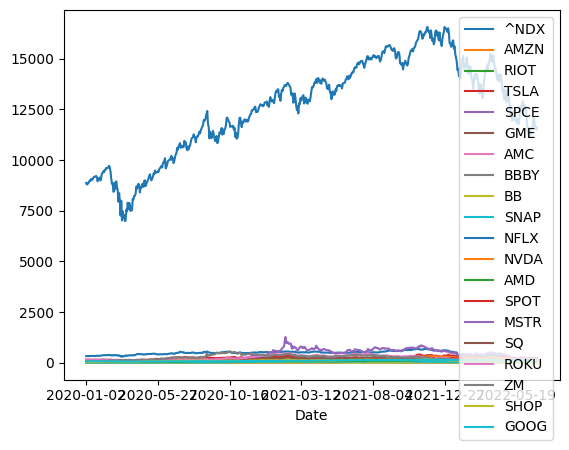

In [69]:
data.plot()

In [70]:
i = 0
while i < len(symbols):
    print('Downloading.... ', i, symbols[i])

    try:
        # Use pandas_datareader.data.DataReader to extract the desired data from Yahoo!
        data[symbols[i]] = pdr.DataReader(symbols[i], 'yahoo', start_date, end_date)['Adj Close']
        i +=1
        
    except:
        print ('Error with connection. Wait for 1 minute to try again...')
        # Wait for 30 seconds
        time.sleep(30)
        continue     

Downloading....  0 AMZN
Downloading....  1 RIOT
Downloading....  2 TSLA
Downloading....  3 SPCE
Downloading....  4 PLTR
Downloading....  5 GME
Downloading....  6 AMC
Downloading....  7 BBBY
Downloading....  8 BB
Downloading....  9 SNAP
Downloading....  10 NFLX
Downloading....  11 NVDA
Downloading....  12 AMD
Downloading....  13 SPOT
Downloading....  14 MSTR
Downloading....  15 SNOW
Downloading....  16 SQ
Downloading....  17 ROKU
Downloading....  18 ZM
Downloading....  19 SHOP
Downloading....  20 GOOG


In [71]:
data.shape

(630, 22)

In [73]:
data.dropna(axis=1).shape

(630, 20)

In [74]:
# Remove the missing values from dataframe
data = data.dropna(axis=1)

In [75]:
# Save data
data.to_csv('data/NASDAQ_idx_and_const.csv')

# Load data

In [79]:
data = pd.read_csv('data/NASDAQ_idx_and_const.csv',index_col=0)

In [80]:
data.head()

,AMZN,RIOT,TSLA,SPCE,GME,AMC,BBBY,BB,SNAP,NFLX,NVDA,AMD,SPOT,MSTR,SQ,ROKU,ZM,SHOP,GOOG
Date,,,,,,,,,,,,,,,,,,,
1/2/2020,94.900497,1.22,28.684000,11.79,1.5775,7.414512,15.967111,6.52,16.780001,329.809998,59.785843,49.099998,151.619995,144.309998,63.830002,137.100006,68.720001,40.780998,68.368500
1/3/2020,93.748497,1.18,29.534000,11.81,1.4700,7.275366,15.722667,6.46,16.750000,325.899994,58.828911,48.599998,152.500000,143.570007,63.000000,137.509995,67.279999,40.429001,68.032997
1/6/2020,95.143997,1.30,30.102667,11.38,1.4625,7.076585,16.191999,6.68,16.780001,335.829987,59.075619,48.389999,156.720001,144.250000,62.570000,143.369995,70.320000,41.333000,69.710503
1/7/2020,95.343002,1.49,31.270666,11.36,1.3800,7.086524,16.465778,6.66,17.030001,330.750000,59.790829,48.250000,156.020004,143.869995,64.589996,138.190002,71.900002,41.450001,69.667000
1/8/2020,94.598503,1.37,32.809334,11.42,1.4300,6.579634,16.279999,6.66,16.670000,339.260010,59.902969,47.830002,158.779999,143.710007,67.599998,134.639999,72.550003,41.810001,70.216003


# Vanilla Autoencoder

We implement a **vanilla Autoencoder (AE)**. The vanilla AE is the simplest form of AE, *which is a neural network with one hidden layer*. The model will take as input
the price of every stock at each time step and will give as output the same values (an approximation). 

An autoencoder is an unsupervised learning model that consists of two parts, **the encoder** and **the decoder**. The encoder maps the input data to a lower-dimensional space (*sound familiar?*) to extract the most robust features from data, and then the decoder interprets these features and uses them to reconstruct the original input.

The encoder will learn a latent lower-dimensional representation from the stock's price series while the decoder will try to reconstruct them from the encoded features.

<img src="images/ae.png"  style="width: 900px;"/>

In [81]:
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Input

In [82]:
equal_weight = 1/len(data.columns)
print(equal_weight)


0.05263157894736842


In [83]:
data_weight = data*equal_weight
print(data_weight)

               AMZN      RIOT       TSLA      SPCE       GME       AMC  \
Date                                                                     
1/2/2020   4.994763  0.064211   1.509684  0.620526  0.083026  0.390237   
1/3/2020   4.934131  0.062105   1.554421  0.621579  0.077368  0.382914   
1/6/2020   5.007579  0.068421   1.584351  0.598947  0.076974  0.372452   
1/7/2020   5.018053  0.078421   1.645825  0.597895  0.072632  0.372975   
1/8/2020   4.978869  0.072105   1.726807  0.601053  0.075263  0.346297   
...             ...       ...        ...       ...       ...       ...   
6/27/2022  5.958947  0.257368  12.890526  0.349474  1.706447  0.743684   
6/28/2022  5.652632  0.250526  12.245438  0.331053  1.636579  0.704211   
6/29/2022  5.732631  0.236842  12.025790  0.315789  1.616579  0.718421   
6/30/2022  5.590000  0.220526  11.814386  0.316842  1.609211  0.713158   
7/1/2022   5.766316  0.223158  11.961228  0.330526  1.623947  0.712105   

               BBBY        BB      SN

In [84]:
data_weight.sum(1)


Date
1/2/2020     68.330472
1/3/2020     67.873760
1/6/2020     69.351940
1/7/2020     69.082305
1/8/2020     69.690340
               ...    
6/27/2022    85.695573
6/28/2022    81.172545
6/29/2022    79.698175
6/30/2022    76.931884
7/1/2022     77.759273
Length: 630, dtype: float64

In [85]:
data.head()

,AMZN,RIOT,TSLA,SPCE,GME,AMC,BBBY,BB,SNAP,NFLX,NVDA,AMD,SPOT,MSTR,SQ,ROKU,ZM,SHOP,GOOG
Date,,,,,,,,,,,,,,,,,,,
1/2/2020,94.900497,1.22,28.684000,11.79,1.5775,7.414512,15.967111,6.52,16.780001,329.809998,59.785843,49.099998,151.619995,144.309998,63.830002,137.100006,68.720001,40.780998,68.368500
1/3/2020,93.748497,1.18,29.534000,11.81,1.4700,7.275366,15.722667,6.46,16.750000,325.899994,58.828911,48.599998,152.500000,143.570007,63.000000,137.509995,67.279999,40.429001,68.032997
1/6/2020,95.143997,1.30,30.102667,11.38,1.4625,7.076585,16.191999,6.68,16.780001,335.829987,59.075619,48.389999,156.720001,144.250000,62.570000,143.369995,70.320000,41.333000,69.710503
1/7/2020,95.343002,1.49,31.270666,11.36,1.3800,7.086524,16.465778,6.66,17.030001,330.750000,59.790829,48.250000,156.020004,143.869995,64.589996,138.190002,71.900002,41.450001,69.667000
1/8/2020,94.598503,1.37,32.809334,11.42,1.4300,6.579634,16.279999,6.66,16.670000,339.260010,59.902969,47.830002,158.779999,143.710007,67.599998,134.639999,72.550003,41.810001,70.216003


In [86]:
# Load data
stocks_data = data.iloc[:,1:]
index_data = data.iloc[:,0]
assets_names = data.iloc[:,1:].columns

print("Stocks data (time series) shape: {shape}".format(shape=stocks_data.shape))
print("Index data (time series) shape: {shape}".format(shape=index_data.shape))

stocks_data.head()

Stocks data (time series) shape: (630, 18)
Index data (time series) shape: (630,)


,RIOT,TSLA,SPCE,GME,AMC,BBBY,BB,SNAP,NFLX,NVDA,AMD,SPOT,MSTR,SQ,ROKU,ZM,SHOP,GOOG
Date,,,,,,,,,,,,,,,,,,
1/2/2020,1.22,28.684000,11.79,1.5775,7.414512,15.967111,6.52,16.780001,329.809998,59.785843,49.099998,151.619995,144.309998,63.830002,137.100006,68.720001,40.780998,68.368500
1/3/2020,1.18,29.534000,11.81,1.4700,7.275366,15.722667,6.46,16.750000,325.899994,58.828911,48.599998,152.500000,143.570007,63.000000,137.509995,67.279999,40.429001,68.032997
1/6/2020,1.30,30.102667,11.38,1.4625,7.076585,16.191999,6.68,16.780001,335.829987,59.075619,48.389999,156.720001,144.250000,62.570000,143.369995,70.320000,41.333000,69.710503
1/7/2020,1.49,31.270666,11.36,1.3800,7.086524,16.465778,6.66,17.030001,330.750000,59.790829,48.250000,156.020004,143.869995,64.589996,138.190002,71.900002,41.450001,69.667000
1/8/2020,1.37,32.809334,11.42,1.4300,6.579634,16.279999,6.66,16.670000,339.260010,59.902969,47.830002,158.779999,143.710007,67.599998,134.639999,72.550003,41.810001,70.216003


In [87]:
stocks_data.values

array([[  1.22000003,  28.68400002,  11.78999996, ...,  68.72000122,
         40.78099823,  68.36849976],
       [  1.17999995,  29.5340004 ,  11.81000042, ...,  67.27999878,
         40.42900085,  68.03299713],
       [  1.29999995,  30.10266685,  11.38000011, ...,  70.31999969,
         41.33300018,  69.71050262],
       ...,
       [  4.5       , 228.4900055 ,   6.        , ..., 111.8700027 ,
         33.04999924, 112.2565002 ],
       [  4.19000006, 224.4733276 ,   6.01999998, ..., 107.9700012 ,
         31.23999977, 109.3724976 ],
       [  4.23999977, 227.2633362 ,   6.28000021, ..., 110.9700012 ,
         31.40999985, 109.0810013 ]])

In [88]:
# Split data
n_train = int(stocks_data.shape[0]*0.8)

# Stocks data
X_train = stocks_data.values[:n_train, :]
X_test = stocks_data.values[n_train:, :]

# Index data
index_train = index_data[:n_train]
index_test = index_data[n_train:]

In [89]:
print(X_train.shape)
print(X_test.shape)

(504, 18)
(126, 18)


In [90]:
# Normalize data
scaler = MinMaxScaler([0, 1])
# Stocks data
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
# Index data
scaler_index = MinMaxScaler([0, 1])
index_train = scaler_index.fit_transform(index_train.values.reshape(-1, 1))
index_test = scaler_index.fit_transform(index_test.values.reshape(-1, 1))

See here how the [Functional API](https://www.tensorflow.org/api_docs/python/tf/keras/Model) of Tensorflow works

In [91]:
n_inputs

19

In [92]:
## Autoencoder - Tensorflow

# Network hyperparameters
n_inputs = X_train.shape[1]

# Training hyperparameters
epochs = 100
batch_size = 1

# Define model
input_l = Input(shape=(n_inputs,))
# Encoder Layers
encoded = Dense(4, input_shape=(n_inputs,), activation='relu')(input_l)

#change to recurrent
decoded = Dense(n_inputs, activation='sigmoid')(encoded)

# Encoder
encoder = Model(input_l, encoded)

# Autoencoder
model = Model(input_l, decoded)

model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 18)]              0         
                                                                 
 dense_6 (Dense)             (None, 4)                 76        
                                                                 
 dense_7 (Dense)             (None, 18)                90        
                                                                 
Total params: 166
Trainable params: 166
Non-trainable params: 0
_________________________________________________________________


In [93]:
# Compile the model
model.compile(loss='mse', optimizer='adam')

We use `X_train` for both the input and the target data, as we are interested in reconstructing the original data.

In [94]:
# Fit the model
history = model.fit(X_train,
                    X_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    shuffle=True,
                    verbose=1
                    )

Epoch 1/100
504/504 [==============================] - 1s 734us/step - loss: 0.0762
Epoch 2/100
504/504 [==============================] - 0s 659us/step - loss: 0.0559
Epoch 3/100
504/504 [==============================] - 0s 668us/step - loss: 0.0422
Epoch 4/100
504/504 [==============================] - 0s 775us/step - loss: 0.0313
Epoch 5/100
504/504 [==============================] - 0s 692us/step - loss: 0.0242
Epoch 6/100
504/504 [==============================] - 0s 694us/step - loss: 0.0195
Epoch 7/100
504/504 [==============================] - 0s 735us/step - loss: 0.0164
Epoch 8/100
504/504 [==============================] - 0s 776us/step - loss: 0.0145
Epoch 9/100
504/504 [==============================] - 0s 682us/step - loss: 0.0133
Epoch 10/100
504/504 [==============================] - 0s 659us/step - loss: 0.0125
Epoch 11/100
504/504 [==============================] - 0s 647us/step - loss: 0.0119
Epoch 12/100
504/504 [==============================] - 0s 614us/step - lo

In [95]:
# List all data recorded in history
print(history.history.keys())

dict_keys(['loss'])


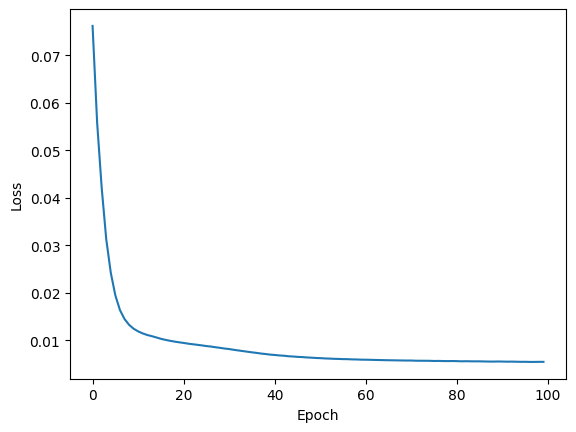

In [96]:
# Visualize training loss
plt.figure()
plt.plot(history.history['loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()
#plt.savefig('images/vanillaAE_loss.png', bbox_inches='tight')

In [97]:
from tensorflow.keras.models import model_from_json

# Save model
# serialize model to JSON
model_json = model.to_json()
with open("models/vanillaAE_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("models/vanillaAE_model.h5")

In [98]:
## Load model
## load json and create model
json_file = open('models/vanillaAE_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("models/vanillaAE_model.h5")

# Compile the model
model.compile(loss='mse', optimizer='adam')

In [99]:
# Evaluate model
score_train = model.evaluate(X_train, X_train, batch_size=batch_size)
score_test = model.evaluate(X_test, X_test, batch_size=batch_size)

print('Training MSE: %.8f' %score_train)
print('Testing MSE: %.8f' %score_test)

126/126 [==============================] - 0s 592us/step - loss: 0.0473
Training MSE: 0.00551552
Testing MSE: 0.04733549


In [100]:
# Obtain reconstruction of the stocks
X_train_pred = model.predict(X_train)
X_test_pred = model.predict(X_test)

# Reconstruction error
error_train = np.mean(np.abs(X_train - X_train_pred)**2, axis=0)
print('Training MSE: %.8f' %np.mean(error_train))

error_test = np.mean(np.abs(X_test - X_test_pred)**2, axis=0)
print('Testing MSE: %.8f' %np.mean(error_test))

4/4 [==============================] - 0s 1ms/step
Training MSE: 0.00551552
Testing MSE: 0.04733551


In [101]:
error_train

array([0.00807577, 0.00597394, 0.00691791, 0.00743067, 0.00179117,
       0.00487074, 0.00343575, 0.00539059, 0.00584964, 0.00324493,
       0.00522452, 0.01049548, 0.00544231, 0.00397713, 0.00432695,
       0.00806396, 0.00614583, 0.00262204])

In [102]:
# Sort stocks by reconstruction error
ind = np.argsort(error_train)
sort_error = error_train[ind]
sort_assets_names = assets_names[ind]

In [103]:
sort_assets_names

Index(['AMC', 'GOOG', 'NVDA', 'BB', 'SQ', 'ROKU', 'BBBY', 'AMD', 'SNAP',
       'MSTR', 'NFLX', 'TSLA', 'SHOP', 'SPCE', 'GME', 'ZM', 'RIOT', 'SPOT'],
      dtype='object')

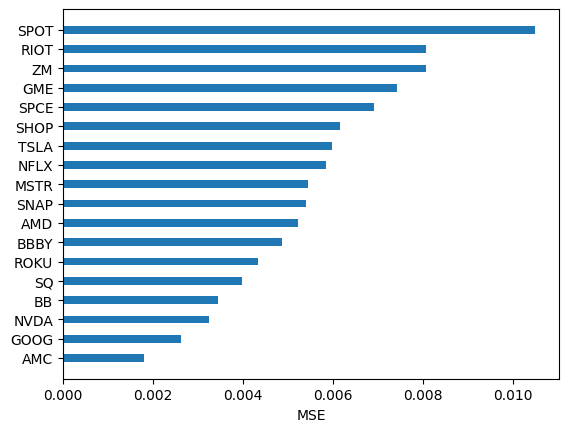

In [104]:
# Barplot
plt.figure()
plt.barh(2*np.arange(len(error_train[:20])), error_train[ind[:20]], tick_label=assets_names[ind[:20]])
plt.xlabel('MSE')
plt.show()
#plt.savefig('images/vanillaAE_MSEbar.png', bbox_inches='tight')

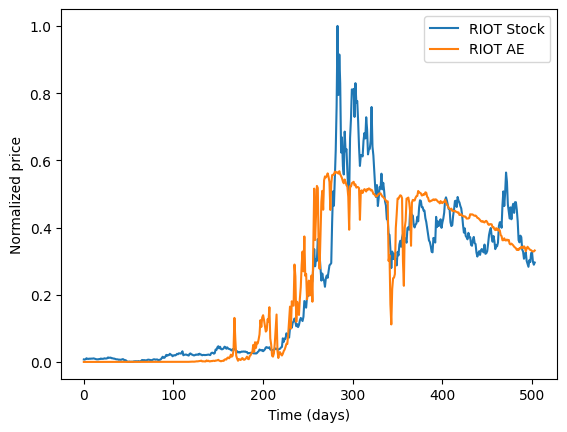

In [107]:
# Plot stock
i = 16
plt.figure()
plt.plot(X_train[:, ind[i]], label=assets_names[ind[i]] + ' Stock')
plt.plot(X_train_pred[:, ind[i]], label=assets_names[ind[i]] + ' AE')
plt.legend()
plt.xlabel('Time (days)')
plt.ylabel('Normalized price')
plt.show()
#plt.savefig('images/vanillaAE_' + assets_names[ind[i]] + '.png', bbox_inches='tight')

In [108]:
# Identify stocks
n = 19

portfolio_train = X_train_pred[:, ind[:n]]
portfolio_test = X_test_pred[:, ind[:n]]

# Create portfolio in-sample
tracked_index_insample = np.mean(portfolio_train, axis=1)

# Create portfolio out-sample
tracked_index_outofsample = np.mean(portfolio_test, axis=1)

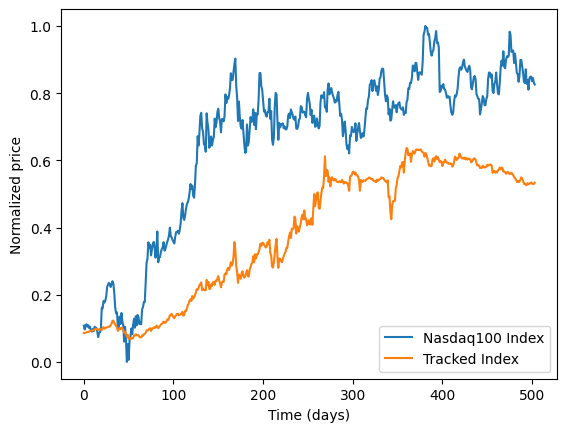

In [109]:
# In-sample
plt.figure()
plt.plot(index_train, label='Nasdaq100 Index')
plt.plot(tracked_index_insample, label='Tracked Index')
plt.legend()
plt.xlabel('Time (days)')
plt.ylabel('Normalized price')
plt.show()
#plt.savefig('images/vanillaAE_insample.png', bbox_inches='tight')

In [110]:
# Correlation coefficient (in-sample)
corr_train = np.corrcoef(index_train.squeeze(), tracked_index_insample)[0, 1]
print('Correlation coefficient (in-sample): %.8f' %corr_train)

Correlation coefficient (in-sample): 0.85655733


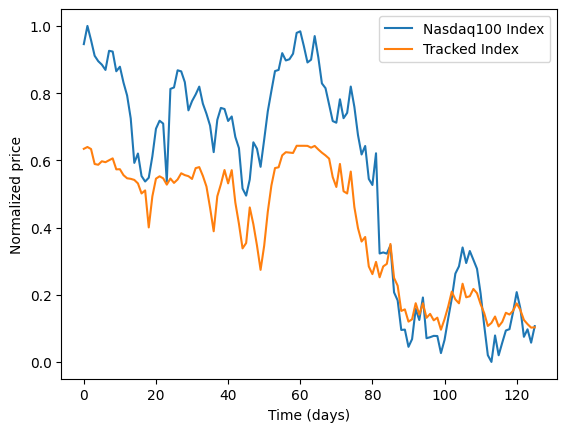

In [111]:
# Plot tracked index (out-of-sample)
plt.figure()
plt.plot(index_test, label='Nasdaq100 Index')
plt.plot(tracked_index_outofsample, label='Tracked Index')
plt.legend()
plt.xlabel('Time (days)')
plt.ylabel('Normalized price')
plt.show()
#plt.savefig('images/vanillaAE_outofsample.png', bbox_inches='tight')

In [112]:
# Correlation coefficient (out-of-sample)
corr_test = np.corrcoef(index_test.squeeze(), tracked_index_outofsample)[0, 1]
print('Correlation coefficient: %.8f' %corr_test)

Correlation coefficient: 0.96704205


In [113]:
# Predict code values
code_values = encoder.predict(X_test)
np.save('models/vanillaAE_code.npy',code_values)

# Compute mean
mean_code = np.mean(code_values, axis=(0, 1))
print('Mean of code values for vanilla AE: %.8f' %mean_code)

4/4 [==============================] - 0s 999us/step
Mean of code values for vanilla AE: 0.58681160


# Deep Autoencoder

In [35]:
## Deep Autoencoder - Tensorflow

# Network hyperparameters
n_inputs = X_train.shape[1]

# Training hyperparameters
epochs = 25
batch_size = 1

# Define model
input = Input(shape=(n_inputs,)) # input
# Encoder Layers
encoded = Dense(16, input_shape=(n_inputs,), activation='relu')(input) # hidden layer
encoded = Dense(8, input_shape=(n_inputs,), activation='relu')(encoded) # hidden layer
encoded = Dense(4, activation='relu')(encoded) # code
decoded = Dense(8, activation='relu')(encoded) # hidden layer
decoded = Dense(16, activation='relu')(decoded) # hidden layer
decoded = Dense(n_inputs, activation='sigmoid')(decoded) # output

# Encoder
encoder = Model(input, encoded)

# Autoencoder
model = Model(input, decoded)

In [36]:
# Compile autoencoder
model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 83)]              0         
                                                                 
 dense_2 (Dense)             (None, 8)                 672       
                                                                 
 dense_3 (Dense)             (None, 4)                 36        
                                                                 
 dense_4 (Dense)             (None, 8)                 40        
                                                                 
 dense_5 (Dense)             (None, 83)                747       
                                                                 
Total params: 1,495
Trainable params: 1,495
Non-trainable params: 0
_________________________________________________________________


In [37]:
# Fit the model
history = model.fit(X_train,
                    X_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    shuffle=True,
                    verbose=1
                    )

Epoch 1/25
2113/2113 [==============================] - 5s 2ms/step - loss: 0.0226
Epoch 2/25
2113/2113 [==============================] - 4s 2ms/step - loss: 0.0072
Epoch 3/25
2113/2113 [==============================] - 4s 2ms/step - loss: 0.0063
Epoch 4/25
2113/2113 [==============================] - 4s 2ms/step - loss: 0.0060
Epoch 5/25
2113/2113 [==============================] - 4s 2ms/step - loss: 0.0058
Epoch 6/25
2113/2113 [==============================] - 4s 2ms/step - loss: 0.0056
Epoch 7/25
2113/2113 [==============================] - 4s 2ms/step - loss: 0.0052
Epoch 8/25
2113/2113 [==============================] - 4s 2ms/step - loss: 0.0049
Epoch 9/25
2113/2113 [==============================] - 4s 2ms/step - loss: 0.0045
Epoch 10/25
2113/2113 [==============================] - 5s 2ms/step - loss: 0.0043
Epoch 11/25
2113/2113 [==============================] - 5s 2ms/step - loss: 0.0043
Epoch 12/25
2113/2113 [==============================] - 4s 2ms/step - loss: 0.0042
E

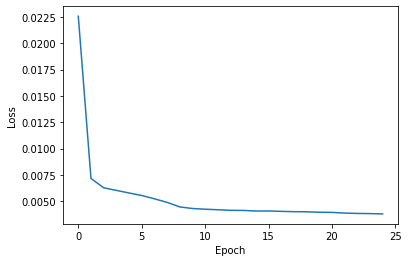

In [38]:
# Visualize loss history
plt.figure()
plt.plot(history.history['loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()
#plt.savefig('images/DAE_loss.eps', bbox_inches='tight')

In [39]:
from keras.models import model_from_json
#
## Save model
## serialize model to JSON
model_json = model.to_json()
with open("models/DAE_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("models/DAE_model.h5")

In [40]:
# load json and create model
json_file = open('models/DAE_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("models/DAE_model.h5")

# Compile the model (otherwise you get an error)
model.compile(loss='mse', optimizer='adam')

In [41]:
# Evaluate model
score_train = model.evaluate(X_train, X_train, batch_size=batch_size)
score_test = model.evaluate(X_test, X_test, batch_size=batch_size)

print('Training MSE: %.8f' %score_train)
print('Testing MSE: %.8f' %score_test)

529/529 [==============================] - 1s 2ms/step - loss: 0.0420
Training MSE: 0.00376222
Training MSE: 0.04196302


In [42]:
# Obtain reconstruction of the stocks
X_train_pred = model.predict(X_train)
X_test_pred = model.predict(X_test)

error = np.mean(np.abs(X_train - X_train_pred)**2, axis=0)
print('Training MSE: %.8f' %np.mean(error))

error_test = np.mean(np.abs(X_test - X_test_pred)**2, axis=0)
print('Testing MSE: %.8f' %np.mean(error_test))

Training MSE: 0.00376222
Testing MSE: 0.04196305


In [43]:
# Sort stocks by reconstruction error
ind = np.argsort(error)
sort_error = error[ind]
sort_assets_names = assets_names[ind]

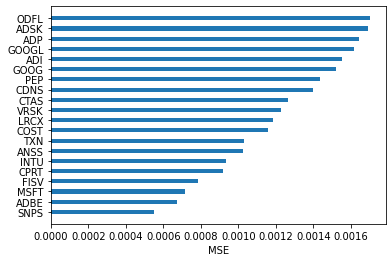

In [44]:
# Barplot
plt.figure()
plt.barh(2*np.arange(len(error[:20])), error[ind[:20]], tick_label=assets_names[ind[:20]])
plt.xlabel('MSE')
plt.show()
#plt.savefig('images/DAE_MSEbar.eps', bbox_inches='tight')

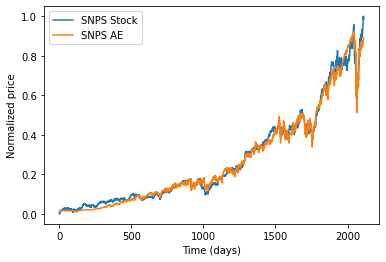

In [45]:
# Plot stock
i=0
plt.figure()
plt.plot(X_train[:, ind[i]], label=assets_names[ind[i]] + ' Stock')
plt.plot(X_train_pred[:, ind[i]], label=assets_names[ind[i]] + ' AE')
plt.legend()
plt.xlabel('Time (days)')
plt.ylabel('Normalized price')
plt.show()
#plt.savefig('images/DAE_' + assets_names[ind[i]] + '.eps', bbox_inches='tight')

In [46]:
# Identify stocks
n = 5

portfolio_train = X_train_pred[:, ind[:n]]
portfolio_test = X_test_pred[:, ind[:n]]

# Create portfolio in-sample
tracked_index_insample = np.mean(portfolio_train, axis=1)

# Create portfolio out-sample
tracked_index_outofsample = np.mean(portfolio_test, axis=1)

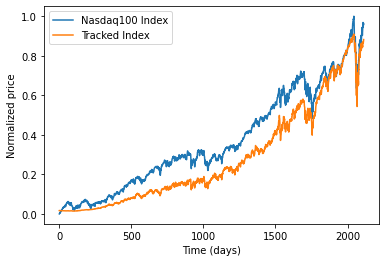

In [47]:
# In-sample
plt.figure()
plt.plot(index_train, label='Nasdaq100 Index')
plt.plot(tracked_index_insample, label='Tracked Index')
plt.legend()
plt.xlabel('Time (days)')
plt.ylabel('Normalized price')
plt.show()
#plt.savefig('images/DAE_insample.png', bbox_inches='tight')

In [48]:
# Correlation coefficient (in-sample)
corr_train = np.corrcoef(index_train.squeeze(), tracked_index_insample)[0, 1]
print('Correlation coefficient (in-sample): %.8f' %corr_train)

Correlation coefficient (in-sample): 0.98068652


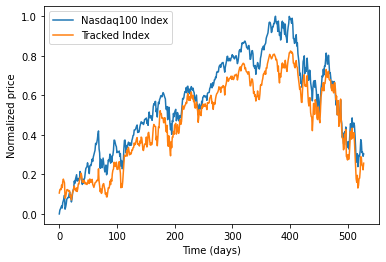

In [49]:
# Plot tracked index (out-of-sample)
plt.figure()
plt.plot(index_test, label='Nasdaq100 Index')
plt.plot(tracked_index_outofsample, label='Tracked Index')
plt.legend()
plt.xlabel('Time (days)')
plt.ylabel('Normalized price')
plt.show()
#plt.savefig('images/DAE_outofsample.png', bbox_inches='tight')

In [50]:
# Correlation coefficient (out-of-sample)
corr_test = np.corrcoef(index_test.squeeze(), tracked_index_outofsample)[0, 1]
print('Correlation coefficient: %.8f' %corr_test)

Correlation coefficient: 0.97491261


# Denoising Autoencoder
By using the vanilla AE implemented so far, where the only constraint is the size of the code layer, usually the hidden layer learns just an approximation of Principal Component Analysis (PCA).


Corrupting the input data is one strategy to make the learned features in the latent space more robust. 

The idea is to train the autoencoder to reconstruct the clean data from its corrupted version. This is known as the **denoising autoencoder**.


How can we corrupt our data? The simplest way is by adding **Gaussian noise**. 

In [51]:
# Load data
stocks_data = data.iloc[:,1:]
index_data = data.iloc[:,0]
assets_names = data.iloc[:,1:].columns

print("Stocks data (time series) shape: {shape}".format(shape=stocks_data.shape))
print("Index data (time series) shape: {shape}".format(shape=index_data.shape))

stocks_data.head()

Stocks data (time series) shape: (2642, 83)
Index data (time series) shape: (2642,)


,AAPL,ADBE,ADI,ADP,ADSK,AEP,ALGN,AMAT,AMD,AMGN,...,SNPS,SWKS,TMUS,TSLA,TXN,VRSK,VRSN,VRTX,WBA,XEL
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,12.540044,28.570000,27.857821,37.355480,30.809999,27.491381,23.950001,8.905310,5.48,48.890965,...,26.990000,14.872287,15.560119,1.872000,22.259815,38.402344,35.820000,32.230000,24.575785,19.223831
2012-01-04,12.607440,28.280001,27.819164,37.314316,30.209999,27.579029,24.410000,8.955247,5.46,48.624035,...,26.490000,14.836918,14.565862,1.847333,22.117708,38.031590,35.820000,32.200001,24.404806,19.097265
2012-01-05,12.747406,28.480000,27.942873,37.588699,30.820000,27.612740,24.190001,9.013505,5.46,49.119732,...,26.850000,15.279026,13.273328,1.808000,22.274776,38.177933,35.740002,33.119999,24.323038,19.181652
2012-01-06,12.880666,28.719999,27.757313,37.643581,30.959999,27.504858,23.709999,9.163314,5.43,49.386665,...,26.870001,15.164070,13.289900,1.794000,22.274776,38.412086,35.400002,34.049999,24.590658,19.125391
2012-01-09,12.860233,28.530001,28.298538,37.499523,31.080000,27.632967,22.670000,9.437964,5.59,48.959583,...,27.040001,15.747650,13.588176,1.816667,22.559011,38.421852,35.020000,35.680000,24.902863,19.139462


In [52]:
# Split data
n_train = int(stocks_data.shape[0]*0.8)

# Stocks data
X_train = stocks_data.values[:n_train, :]
X_test = stocks_data.values[n_train:, :]

# Index data
index_train = index_data[:n_train]
index_test = index_data[n_train:]

In [53]:
# Normalize data
scaler = MinMaxScaler([0, 1])
# Stocks data
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
# Index data
scaler_index = MinMaxScaler([0, 1])
index_train = scaler_index.fit_transform(index_train.values.reshape(-1,1))
index_test = scaler_index.fit_transform(index_test.values.reshape(-1,1))

In [54]:
# Generate corrupted series by adding noise with normal distribution
noise_factor = 0.05
X_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape)
X_test_noisy = X_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape)

# Clip corrupted data
X_train_noisy = np.clip(X_train_noisy, 0., 1.)
X_test_noisy = np.clip(X_test_noisy, 0., 1.)

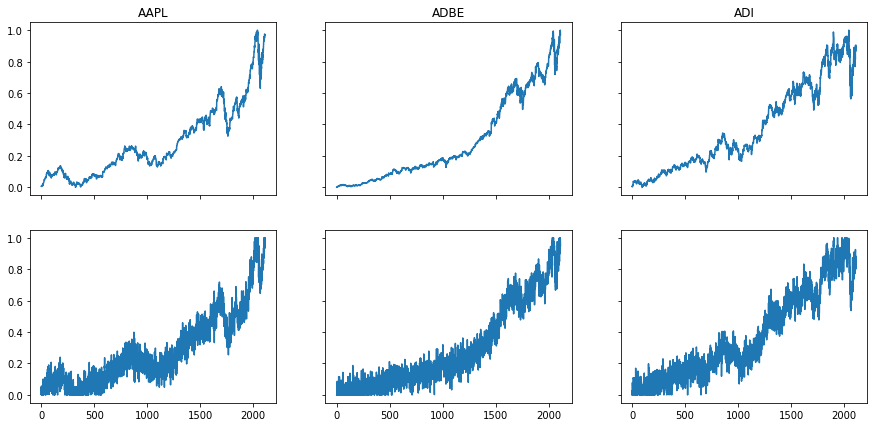

In [55]:
# Visualize corrupted data
f, axarr = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(15,7))

# Asset 1
axarr[0,0].plot(X_train[:, 0])
axarr[0,0].set_title(assets_names[0])
axarr[1,0].plot(X_train_noisy[:, 0])

# Asset 2
axarr[0,1].plot(X_train[:, 1])
axarr[0,1].set_title(assets_names[1])
axarr[1,1].plot(X_train_noisy[:, 1])

# Asset 3
axarr[0,2].plot(X_train[:, 2])
axarr[0,2].set_title(assets_names[2])
axarr[1,2].plot(X_train_noisy[:, 2])

plt.show()
#plt.savefig('denoisingAE_noisydata.png', bbox_inches='tight')

In [56]:
## Autoencoder - Tensorflow

# Network hyperparameters
n_inputs = X_train.shape[1]

# Training hyperparameters
epochs = 25
batch_size = 1

# Define model
input = Input(shape=(n_inputs,))
# Encoder Layers
encoded = Dense(4, input_shape=(n_inputs,), activation='relu')(input)
decoded = Dense(n_inputs, activation='sigmoid')(encoded)

# Encoder
encoder = Model(input, encoded)

# Autoencoder
model = Model(input, decoded)

In [57]:
# Compile autoencoder
model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 83)]              0         
                                                                 
 dense_6 (Dense)             (None, 4)                 336       
                                                                 
 dense_7 (Dense)             (None, 83)                415       
                                                                 
Total params: 751
Trainable params: 751
Non-trainable params: 0
_________________________________________________________________


In [58]:
# Fit the model
history = model.fit(X_train_noisy,
                    X_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    shuffle=True,
                    verbose=1
                    )

Epoch 1/25
2113/2113 [==============================] - 4s 2ms/step - loss: 0.0406
Epoch 2/25
2113/2113 [==============================] - 4s 2ms/step - loss: 0.0131
Epoch 3/25
2113/2113 [==============================] - 4s 2ms/step - loss: 0.0079
Epoch 4/25
2113/2113 [==============================] - 4s 2ms/step - loss: 0.0063
Epoch 5/25
2113/2113 [==============================] - 4s 2ms/step - loss: 0.0053
Epoch 6/25
2113/2113 [==============================] - 4s 2ms/step - loss: 0.0046
Epoch 7/25
2113/2113 [==============================] - 4s 2ms/step - loss: 0.0043
Epoch 8/25
2113/2113 [==============================] - 4s 2ms/step - loss: 0.0041
Epoch 9/25
2113/2113 [==============================] - 4s 2ms/step - loss: 0.0040
Epoch 10/25
2113/2113 [==============================] - 5s 2ms/step - loss: 0.0039
Epoch 11/25
2113/2113 [==============================] - 4s 2ms/step - loss: 0.0038
Epoch 12/25
2113/2113 [==============================] - 4s 2ms/step - loss: 0.0037
E

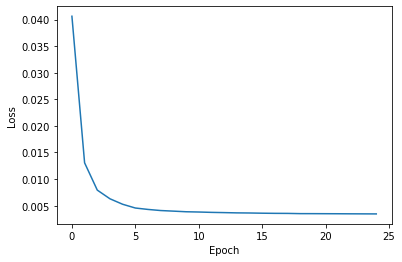

In [59]:
# Visualize loss history
plt.figure()
plt.plot(history.history['loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()
#plt.savefig('images/denoisingAE_loss.png', bbox_inches='tight')

In [60]:
#from keras.models import model_from_json
#
## Save model
## serialize model to JSON
#model_json = model.to_json()
#with open("models/denoisingAE_model.json", "w") as json_file:
#    json_file.write(model_json)
## serialize weights to HDF5
#model.save_weights("models/denoisingAE_model.h5")

In [61]:
## Load model
## load json and create model
#json_file = open('models/denoisingAE_model.json', 'r')
#loaded_model_json = json_file.read()
#json_file.close()
#model = model_from_json(loaded_model_json)
## load weights into new model
#model.load_weights("models/denoisingAE_model.h5")

In [62]:
# Evaluate model
score_train = model.evaluate(X_train_noisy, X_train, batch_size=batch_size)
score_test = model.evaluate(X_test_noisy, X_test, batch_size=batch_size)

print('Training MSE: %.8f' %score_train)
print('Training MSE: %.8f' %score_test)

529/529 [==============================] - 1s 2ms/step - loss: 0.0413
Training MSE: 0.00339711
Training MSE: 0.04130471


In [63]:
# Obtain reconstruction of the stocks
X_train_pred = model.predict(X_train_noisy)
X_test_pred = model.predict(X_test_noisy)

error = np.mean(np.abs(X_train - X_train_pred)**2, axis=0)
print('Training MSE: %.8f' %np.mean(error))

error_test = np.mean(np.abs(X_test - X_test_pred)**2, axis=0)
print('Testing MSE: %.8f' %np.mean(error_test))

Training MSE: 0.00339711
Testing MSE: 0.04130471


In [64]:
# Sort stocks by reconstruction error
ind = np.argsort(error)
sort_error = error[ind]
sort_assets_names = assets_names[ind]

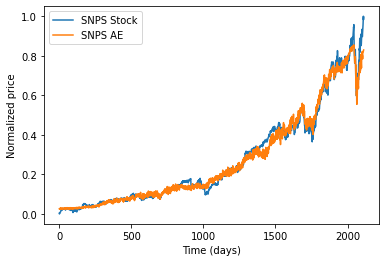

In [65]:
# Plot
i = 0
plt.figure()
plt.plot(X_train[:, ind[i]], label=assets_names[ind[i]] + ' Stock')
plt.plot(X_train_pred[:, ind[i]], label=assets_names[ind[i]] + ' AE')
plt.legend()
plt.xlabel('Time (days)')
plt.ylabel('Normalized price')
plt.show()
#plt.savefig('images/denoisingAE_' + assets_names[ind[i]] + '.eps', bbox_inches='tight')

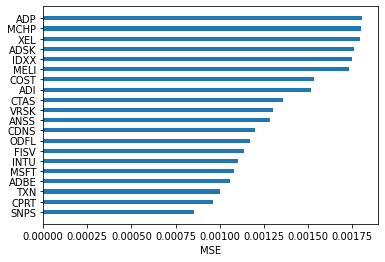

In [66]:
# Barplot
plt.figure()
plt.barh(2*np.arange(len(error[:20])), error[ind[:20]], tick_label=assets_names[ind[:20]])
plt.xlabel('MSE')
#plt.xticks(rotation=25)
plt.show()
#plt.savefig('images/denoisingAE_MSEbar.png', bbox_inches='tight')

In [67]:
# Identify stocks
n = 5

portfolio_train = X_train_pred[:, ind[:n]]
portfolio_test = X_test_pred[:, ind[:n]]

# Create portfolio in-sample
tracked_index_insample = np.mean(portfolio_train, axis=1)

# Create portfolio out-sample
tracked_index_outofsample = np.mean(portfolio_test, axis=1)

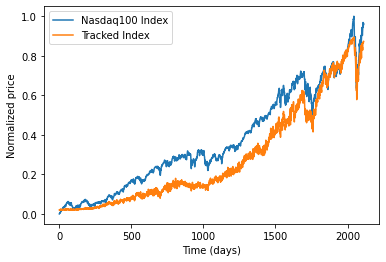

In [68]:
# In-sample
plt.figure()
plt.plot(index_train, label='Nasdaq100 Index')
plt.plot(tracked_index_insample, label='Tracked Index')
plt.legend()
plt.xlabel('Time (days)')
plt.ylabel('Normalized price')
plt.show()
#plt.savefig('images/denoisingAE_insample.png', bbox_inches='tight')

In [69]:
# Correlation coefficient (in-sample)
corr_train = np.corrcoef(index_train.squeeze(), tracked_index_insample)[0, 1]
print('Correlation coefficient (in-sample): %.8f' %corr_train)

Correlation coefficient (in-sample): 0.97804621


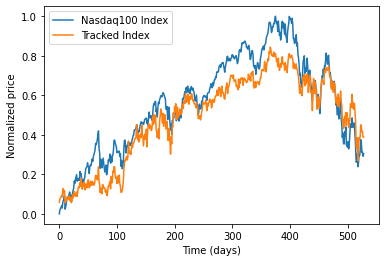

In [70]:
# Plot tracked index (out-of-sample)
plt.figure()
plt.plot(index_test, label='Nasdaq100 Index')
plt.plot(tracked_index_outofsample, label='Tracked Index')
plt.legend()
plt.xlabel('Time (days)')
plt.ylabel('Normalized price')
plt.show()
#plt.savefig('images/denoisingAE_outofsample.png', bbox_inches='tight')

In [71]:
# Correlation coefficient (out-of-sample)
corr_test = np.corrcoef(index_test.squeeze(), tracked_index_outofsample)[0, 1]
print('Correlation coefficient: %.8f' %corr_test)

Correlation coefficient: 0.95239575


# Sparse Autoencoder

Another way to facilitate the learning of more interesting and useful features for the autoencoder is by imposing the sparsity constraint on the output of the code layer. The idea is to switch off different connections at each timestep to learn a code representation that minimizes the reconstruction error by using a small combination of code features.

We achieve this by adding a **penalty term** to the optimization objective. In TF, this can be done by adding `activity_regularizer` to the `Dense` layer to apply a penalty on layer activity during training, which is included in the loss function. For more info check this [article](https://analyticsindiamag.com/what-is-activity-regularization-in-neural-networks/).

In [72]:
## Autoencoder - Keras

# Network hyperparameters
n_inputs = X_train.shape[1]

# Training hyperparameters
epochs = 25
batch_size = 1

# Define model
input = Input(shape=(n_inputs,))
# Encoder Layers
encoded = Dense(4, input_shape=(n_inputs,), activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-5))(input)
decoded = Dense(n_inputs, activation='sigmoid')(encoded)

# Encoder
encoder = Model(input, encoded)

# Autoencoder
model = Model(input, decoded)

In [73]:
# Compile autoencoder
model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 83)]              0         
                                                                 
 dense_8 (Dense)             (None, 4)                 336       
                                                                 
 dense_9 (Dense)             (None, 83)                415       
                                                                 
Total params: 751
Trainable params: 751
Non-trainable params: 0
_________________________________________________________________


In [74]:
# Fit the model
history = model.fit(X_train,
                    X_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    shuffle=True,
                    verbose=1
                    )

Epoch 1/25
2113/2113 [==============================] - 5s 2ms/step - loss: 0.0486
Epoch 2/25
2113/2113 [==============================] - 4s 2ms/step - loss: 0.0223
Epoch 3/25
2113/2113 [==============================] - 3s 2ms/step - loss: 0.0144
Epoch 4/25
2113/2113 [==============================] - 4s 2ms/step - loss: 0.0117
Epoch 5/25
2113/2113 [==============================] - 4s 2ms/step - loss: 0.0105
Epoch 6/25
2113/2113 [==============================] - 4s 2ms/step - loss: 0.0098
Epoch 7/25
2113/2113 [==============================] - 4s 2ms/step - loss: 0.0096
Epoch 8/25
2113/2113 [==============================] - 4s 2ms/step - loss: 0.0094
Epoch 9/25
2113/2113 [==============================] - 4s 2ms/step - loss: 0.0092
Epoch 10/25
2113/2113 [==============================] - 4s 2ms/step - loss: 0.0091
Epoch 11/25
2113/2113 [==============================] - 3s 1ms/step - loss: 0.0090
Epoch 12/25
2113/2113 [==============================] - 4s 2ms/step - loss: 0.0088
E

In [75]:
#from keras.models import model_from_json
#
## Save model
## serialize model to JSON
#model_json = model.to_json()
#with open("models/sparseAE_model.json", "w") as json_file:
#    json_file.write(model_json)
## serialize weights to HDF5
#model.save_weights("models/sparseAE_model.h5")

In [76]:
## Load model
## load json and create model
#json_file = open('models/sparseAE_model.json', 'r')
#loaded_model_json = json_file.read()
#json_file.close()
#model = model_from_json(loaded_model_json)
# load weights into new model
#model.load_weights("models/sparseAE_model.h5")

In [77]:
# Obtain reconstruction of the stocks
X_train_pred = model.predict(X_train)
X_test_pred = model.predict(X_test)

error = np.mean(np.abs(X_train - X_train_pred)**2, axis=0)
print('Training MSE: %.8f' %np.mean(error))

error_test = np.mean(np.abs(X_test - X_test_pred)**2, axis=0)
print('Testing MSE: %.8f' %np.mean(error_test))

Training MSE: 0.00818343
Testing MSE: 0.05906497


In [78]:
# Sort stocks by reconstruction error (increasing order)
ind = np.argsort(error) 
sort_error = error[ind]
sort_assets_names = assets_names[ind]

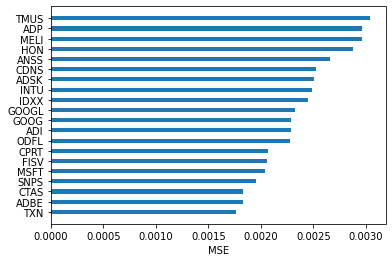

In [79]:
# Barplotplt.figure()
plt.barh(2*np.arange(len(error[:20])), error[ind[:20]], tick_label=assets_names[ind[:20]])
plt.xlabel('MSE')
plt.show()
#plt.savefig('images/sparseAE_MSEbar.eps', bbox_inches='tight')

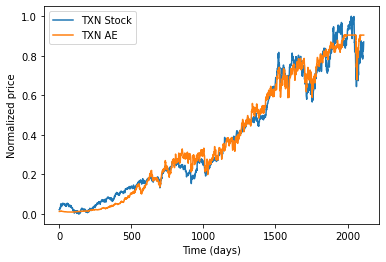

In [80]:
# Plot stock
i = 0
plt.figure()
plt.plot(X_train[:, ind[i]], label=assets_names[ind[i]] + ' Stock')
plt.plot(X_train_pred[:, ind[i]], label=assets_names[ind[i]] + ' AE')
#plt.plot(index_train, label='Nasdaq100')
plt.legend()
plt.xlabel('Time (days)')
plt.ylabel('Normalized price')
plt.show()
#plt.savefig('images/sparseAE_' + assets_names[ind[i]] + '.eps', bbox_inches='tight')

In [81]:
# Identify stocks
n = 5

portfolio_train = X_train_pred[:, ind[:n]]
portfolio_test = X_test_pred[:, ind[:n]]

# Create portfolio in-sample
tracked_index_insample = np.mean(portfolio_train, axis=1)

# Create portfolio out-sample
tracked_index_outofsample = np.mean(portfolio_test, axis=1)

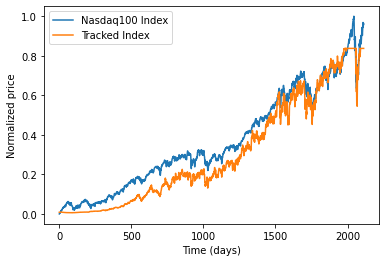

In [82]:
# In-sample
plt.figure()
plt.plot(index_train, label='Nasdaq100 Index')
plt.plot(tracked_index_insample, label='Tracked Index')
plt.legend()
plt.xlabel('Time (days)')
plt.ylabel('Normalized price')
plt.show()
#plt.savefig('images/sparseAE_insample.png', bbox_inches='tight')

In [83]:
# Correlation coefficient (in-sample)
corr_train = np.corrcoef(index_train.squeeze(), tracked_index_insample)[0, 1]
print('Correlation coefficient (in-sample): %.8f' %corr_train)

Correlation coefficient (in-sample): 0.99060674


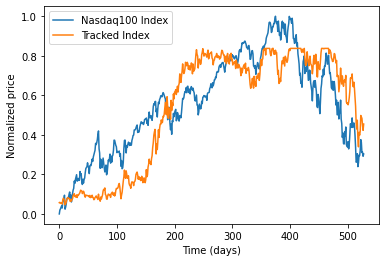

In [84]:
# Plot tracked index (out-of-sample)
plt.figure()
plt.plot(index_test, label='Nasdaq100 Index')
plt.plot(tracked_index_outofsample, label='Tracked Index')
plt.legend()
plt.xlabel('Time (days)')
plt.ylabel('Normalized price')
plt.show()
#plt.savefig('images/sparseAE_outofsample.png', bbox_inches='tight')

In [85]:
# Correlation coefficient (out-of-sample)
corr_test = np.corrcoef(index_test.squeeze(), tracked_index_outofsample)[0, 1]
print('Correlation coefficient: %.8f' %corr_test)

Correlation coefficient: 0.85087710


In [86]:
# Predict code values
code_values = encoder.predict(X_test)

# Compute mean
mean_code = np.mean(code_values, axis=(0, 1))

print('Mean of code values for sparse AE: %.8f' %mean_code)

Mean of code values for sparse AE: 0.20349212


In [87]:
# Compute mean for Vanilla AE
code_vanillaAE = np.load('models/vanillaAE_code.npy')
mean_code_vanillaAE = np.mean(code_vanillaAE, axis=(0, 1))

print('Mean of code values for vanilla AE: %.8f' %mean_code_vanillaAE)

Mean of code values for vanilla AE: 2.21515989


C:\Users\ab978\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\ab978\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


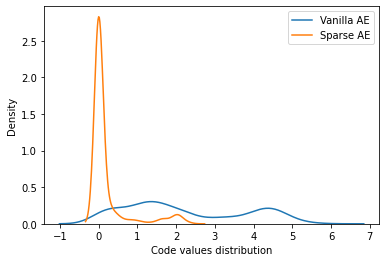

In [88]:
import seaborn as sns
from scipy.stats import norm

# Density Plot - Sparse AE code Vs. Vanilla AE code
fig,ax = plt.subplots()
sns.distplot(code_vanillaAE, hist=False,  kde=True, fit_kws={"color":"green"}, label = 'Vanilla AE',ax=ax)
sns.distplot(code_values, hist=False,  kde=True, fit_kws={"color":"red"}, label = 'Sparse AE',ax=ax)
ax.set_xlabel('Code values distribution')
ax.set_ylabel('Density')
ax.legend()

#plt.savefig('images/sparseAE_code.png', bbox_inches='tight')